In [2]:
import nltk
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import string
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import random
import re
import seaborn as sns
from nltk.stem import PorterStemmer
nltk.download('twitter samples')
nltk.download('stopwords')

[nltk_data] Error loading twitter samples: Package 'twitter samples'
[nltk_data]     not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
test_pos = positive_tweets[4000:]
train_pos = positive_tweets[:4000]
test_neg = negative_tweets[4000:]
train_neg = negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

In [5]:
train_y = np.append(np.ones(len(train_pos)),np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)),np.zeros(len(test_neg)))


<BarContainer object of 2 artists>

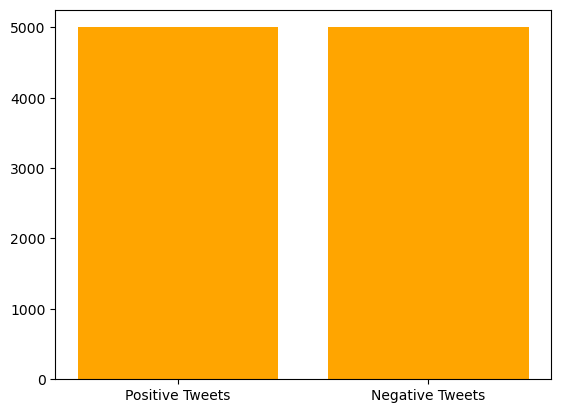

In [6]:
plt.bar(['Positive Tweets','Negative Tweets'],[len(positive_tweets),len(negative_tweets)],color='orange')

<BarContainer object of 2 artists>

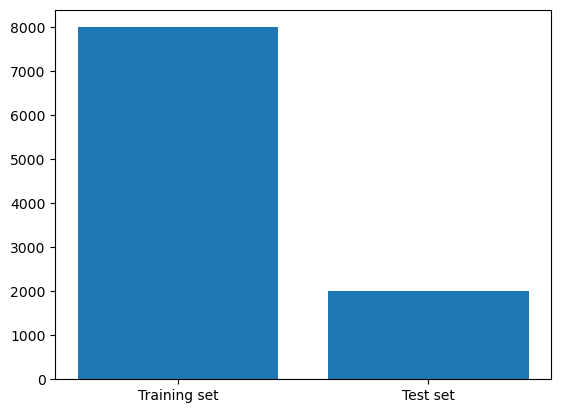

In [7]:
plt.bar(['Training set','Test set'],[len(train_x),len(test_x)])

In [8]:
#check postive tweets
print('Positive tweet example: ' + positive_tweets[random.randint(0,5000)])

Positive tweet example: @RookieSenpai @arcadester it is the id conflict thanks for the help :D here's the screenshot of it working


In [9]:
#check negative tweets
print('Negative tweet example: ' + negative_tweets[random.randint(0,5000)])

Negative tweet example: @StaMar999 I booked trip before crisis. :(((


THIS CSV FILE CONSISTS OF VALUES OF POSITIVE LOG PROBABILITY, NEGATIVE LOG PROBABILITY AND ASSOCIATED LABEL

In [10]:
features = pd.read_csv('bayes_features.csv')

In [11]:
features.head()

,positive,negative,sentiment
0,-45.763393,-63.351354,1.0
1,-105.491568,-114.204862,1.0
2,-57.028078,-67.216467,1.0
3,-10.055885,-18.589057,1.0
4,-125.749270,-138.334845,1.0


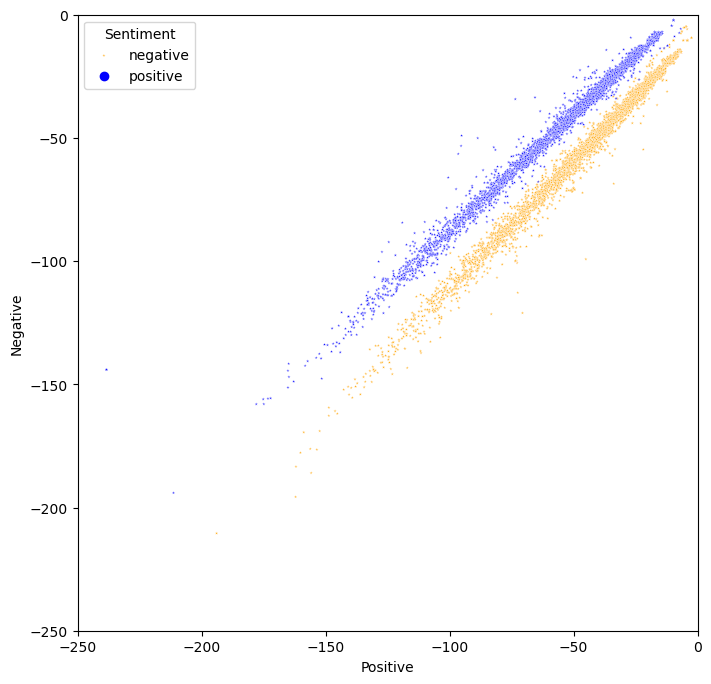

In [12]:
colors = ['blue', 'orange']
sentiments = ['negative', 'positive']

# Create a scatter plot using seaborn
plt.figure(figsize=(8, 8))
sns.scatterplot(x='positive', y='negative', hue='sentiment', data=features, palette=colors, s=5, marker='*')

# Custom limits for this chart
plt.xlim(-250, 0)
plt.ylim(-250, 0)

plt.xlabel("Positive")
plt.ylabel("Negative")

# Add a legend
plt.legend(title='Sentiment', labels=sentiments)

plt.show()


START OF PREPROCESSING OF TEXT

Preprocessing Steps
<ul>
    <li>Tokenizing the string</li>
    <li>Lowercasing</li>
    <li>Removal of stop words</li>
    <li>Stemming</li>
</ul>

In [13]:
def preprocess(tweet):
    #remove retweet text "RT"
    tweet2 = re.sub(r'^RT[\s]+','',tweet)

    #remove hyperlinks
    tweet2 = re.sub(r'https?://[^\s\n\r]+','',tweet2)

    #remove hastag from front of the word
    tweet2 = re.sub(r'#','',tweet2)


    #tokenizer tweet
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)

    tweet_tokens = tokenizer.tokenize(tweet2)


    #remove stopwords and punctuations
    tweets_clean = []
    stopwords_english = stopwords.words('english')
    for word in tweet_tokens:
        if (word not in stopwords_english and 
            word not in string.punctuation):
            tweets_clean.append(word)


    #perform stemming        
    stemmer = PorterStemmer()
    tweets_stem = []
    for word in tweets_clean:
        stem_word = stemmer.stem(word)
        tweets_stem.append(stem_word)
    

    return tweets_stem
        

In [14]:
def count_tweets(result,tweets,ys):
    for y,tweet in zip(ys,tweets):
        for word in preprocess(tweet):
            pair = (word,y)
            if pair in result:
                result[pair] +=1
            else:
                result[pair] = 1
    
    return result


In [15]:
freq = count_tweets({},train_x,train_y)

In [16]:
def naive_bayes_train(freq,train_x,train_y):

    loglikelihood={}
    #create vocab
    words = [key[0] for key in freq.keys()]
    vocab = set(words)
    V = len(vocab)

    #calculate number or positive and negative words
    N_pos = N_neg = 0
    for pair in freq.keys():
        if pair[1] > 0:
            N_pos += freq[pair]
        else:
            N_neg += freq[pair]

    #calculating total number of tweets in train
    D = len(train_y)
    D_pos = sum(train_y)
    D_neg = D - D_pos

    logprior = np.log(D_pos) - np.log(D_neg)
    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freq.get((word, 1), 0)
        freq_neg = freq.get((word, 0), 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood


In [17]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    #preprocess the test tweet
    word_l = preprocess(tweet)

    #assign the value of logprior to p
    p = logprior

    #for all the words in processed tweet calcualte loglikehood
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [18]:
logprior, loglikelihood = naive_bayes_train(freq, train_x, train_y)

In [19]:
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.5576311613097749


In [20]:
my_tweet = 'He laughed.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is -0.16513543643132847


In [21]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    #test the accuracy of prediction of the model
    y_hats = []

    for tweet in test_x:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0

        y_hats.append(y_hat_i)

    accuracy = np.mean(y_hats == test_y)

    return accuracy


In [22]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9955


In [23]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Combine the positive and negative tweets and create labels
tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

# Preprocess the tweets
processed_tweets = [' '.join(preprocess(tweet)) for tweet in tweets]

# Split the dataset into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(processed_tweets, labels, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical feature vectors
vectorizer = CountVectorizer()
train_vectors = vectorizer.fit_transform(train_x)
test_vectors = vectorizer.transform(test_x)

# Create a Complement Naive Bayes classifier
cnb_classifier = ComplementNB()

# Train the classifier
cnb_classifier.fit(train_vectors, train_y)

# Make predictions on the test set
predictions = cnb_classifier.predict(test_vectors)

# Evaluate the model
accuracy = accuracy_score(test_y, predictions)
print("Accuracy:", accuracy)

report = classification_report(test_y, predictions)
print("Classification Report:\n", report)


Accuracy: 0.7405
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       988
           1       0.76      0.71      0.74      1012

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

processed_tweets = [' '.join(preprocess(tweet)) for tweet in tweets]

print(processed_tweets)

train_x, test_x, train_y, test_y = train_test_split(processed_tweets, labels, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
train_vectors = vectorizer.fit_transform(train_x).toarray()
test_vectors = vectorizer.transform(test_x).toarray()

catnb_classifier = GaussianNB(priors=[0.5, 0.5])


catnb_classifier.fit(train_vectors, train_y)


predictions = catnb_classifier.predict(test_vectors)

accuracy = accuracy_score(test_y, predictions)
print("Accuracy:", accuracy)

report = classification_report(test_y, predictions)
print("Classification Report:\n", report)

['followfriday top engag member commun week :)', 'hey jame odd :/ pleas call contact centr 02392441234 abl assist :) mani thank', 'listen last night :) bleed amaz track scotland', 'congrat :)', 'yeaaah yipppi accnt verifi rqst succeed got blue tick mark fb profil :) 15 day', 'one irresist :) flipkartfashionfriday', 'like keep love custom wait long hope enjoy happi friday lwwf :)', 'second thought ’ enough time dd :) new short enter system sheep must buy', 'jgh go bayan :d bye', 'act mischiev call etl layer in-hous wareh app katamari well … name impli :p', 'followfriday top influenc commun week :)', 'love big ... juici ... selfi :)', 'follow follow u back :)', "perfect alreadi know what' wait :)", 'great new opportun junior triathlet age 12 13 gatorad seri get entri :)', 'lay greet card rang print today love job :-)', "friend' lunch ... yummm :) nostalgia tb ku", "id conflict thank help :d here' screenshot work", 'hi liv :)', 'hello need know someth u fm twitter — sure thing :) dm x', '